<div style='font-size:250%; font-weight:bold; text-align:center'>GoFast data analysis</div>

<a id="section1"></a>
# Project description
        Nowadays, scooter-sharing services are popular among people in post-Soviet countries. Due to the fact that scooters can be picked up and left anywhere within city limits, have low rental prices, and allow users to avoid traffic jams, they are a convenient mode of transportation. Using data provided by the ‘GoFast’ scooter-sharing service, which includes three dataframes (user data, trip data, and subscription types), I will analyze this information to help make strategically sound decisions for the marketing and finance departments.

<a id="section2"></a> 
# Purpose of research
1. Calculate the profit.
2. Determine the most profitable subscription type.
3. Test the hypothesis given by marketing department.

<a id="section3"></a> 
# Data description

<br>
<div style='font-weight:bold'> User data ( 'users_go.csv' )
    </div>

- `user_id` - user's unique ID
- `name` -  first name
- `age` - age
- `city` - city
- `subscription_type` - subscription type (free, ultra)

<br>
<div style='font-weight:bold'> Trips data ( 'rides_go.csv' )
    </div>

- `user_id` - user's unique ID
- `distance` - distance of user's last session (in meters)
- `duration` - the duration of the session (in minutes), measured from the moment the user clicks the “Start Trip” button to the moment they click the “End Trip” button.
- `date` - the date of the trip

<br>
<div style='font-weight:bold'> Subscription types ( 'subscriptions_go.csv' )
    </div>

- `subscription_type` - subscription type (free, ultra)
- `minute_price` - price of one minute of ride
- `start_ride_price` - price to start a ride
- `subscription_fee` - subscription monthly fee 

<a id="section4"></a> 
# Step 0. Libraries import 

In [1]:
#importing libs
import pandas as pd
import seaborn as sb
import math
import matplotlib.pyplot as plt
import numpy as np
from transliterate import translit
from scipy import stats as st
from scipy.stats import binom, poisson
from fractions import Fraction

# Step 1. Data upload
<a id="section5"></a> 

In [2]:
#reading csv tables and saving them in variables
try:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'])
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')
except: 
    users = pd.read_csv('/Users/nurasyl/Desktop/datasets/gofast/users_go.csv')
    rides = pd.read_csv('/Users/nurasyl/Desktop/datasets/gofast/rides_go.csv',
                        parse_dates=['date']
                       )
    subscriptions = pd.read_csv('/Users/nurasyl/Desktop/datasets/gofast/subscriptions_go.csv')

In [3]:
#transliterating the dataframes' columns from cyrillic to english
users['name'] = users['name'].apply(lambda x: translit(x, 'ru', reversed=True))
replacements_dict = {
    'Тюмень': 'Tyumen',
    'Омск': 'Omsk',
    'Москва': 'Moscow',
    'Ростов-на-Дону': 'Rostov-on-Don',
    'Краснодар': 'Krasnodar',
    'Пятигорск': 'Pyatigorsk',
    'Екатеринбург': 'Yekaterinburg',
    'Сочи': 'Sochi'
}
users['city'] = users['city'].replace(replacements_dict)

In [4]:
#function for checking general information about dataframe
def data_check(data):
    print("Data Info:\n")
    data.info()
    
    print("\nNumerical data description:")
    try:
        display(data.select_dtypes(exclude='object').describe())
    except:
        print('Numerical data is missing')
    print("String data description:")
    try:
        display(data.select_dtypes(include='object').describe())
    except:
        print('String data is missing')
    
    print("\nFirst 10 Rows:")
    display(data.head(10))
    
    print("\nNumber of Duplicated Rows:\n", data.duplicated().sum())
    
    print("\nMissing Values:\n", data.isna().sum().sum())
    
    print("\nDataFrame Shape:\n", data.shape)

In [5]:
data_check(users)

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB

Numerical data description:


,user_id,age
count,1565.000000,1565.000000
mean,762.633866,24.922045
std,443.260155,4.553496
min,1.000000,12.000000
25%,378.000000,22.000000
50%,762.000000,25.000000
75%,1146.000000,28.000000
max,1534.000000,43.000000


String data description:


,name,city,subscription_type
count,1565,1565,1565
unique,194,8,2
top,Marija,Pyatigorsk,free
freq,23,226,846



First 10 Rows:


,user_id,name,age,city,subscription_type
0,1,Kira,22,Tyumen,ultra
1,2,Stanislav,31,Omsk,ultra
2,3,Aleksej,20,Moscow,ultra
3,4,Konstantin,26,Rostov-on-Don,ultra
4,5,Adel',28,Omsk,ultra
5,6,Regina,25,Krasnodar,ultra
6,7,Igor',23,Omsk,ultra
7,8,Jurij,23,Krasnodar,ultra
8,9,Jan,21,Pyatigorsk,ultra
9,10,Valerij,18,Yekaterinburg,ultra



Number of Duplicated Rows:
 31

Missing Values:
 0

DataFrame Shape:
 (1565, 5)


In [6]:
data_check(rides);

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB

Numerical data description:


,user_id,distance,duration,date
count,18068.000000,18068.000000,18068.000000,18068
mean,842.869936,3070.659976,17.805011,2021-06-30 19:47:21.266327296
min,1.000000,0.855683,0.500000,2021-01-01 00:00:00
25%,487.000000,2543.226360,13.597563,2021-04-02 00:00:00
50%,889.000000,3133.609994,17.678395,2021-06-30 00:00:00
75%,1213.250000,3776.222735,21.724800,2021-09-28 00:00:00
max,1534.000000,7211.007745,40.823963,2021-12-30 00:00:00
std,434.734317,1116.831209,6.091051,NaN


String data description:
String data is missing

First 10 Rows:


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28
5,1,2770.890808,16.650138,2021-10-09
6,1,3039.020292,14.927879,2021-10-19
7,1,2842.118050,23.117468,2021-11-06
8,1,3412.690668,15.238072,2021-11-14
9,1,748.690645,15.041884,2021-11-22



Number of Duplicated Rows:
 0

Missing Values:
 0

DataFrame Shape:
 (18068, 4)


In [7]:
data_check(subscriptions);

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes

Numerical data description:


,minute_price,start_ride_price,subscription_fee
count,2.000000,2.000000,2.000000
mean,7.000000,25.000000,99.500000
std,1.414214,35.355339,140.714249
min,6.000000,0.000000,0.000000
25%,6.500000,12.500000,49.750000
50%,7.000000,25.000000,99.500000
75%,7.500000,37.500000,149.250000
max,8.000000,50.000000,199.000000


String data description:


,subscription_type
count,2
unique,2
top,free
freq,1



First 10 Rows:


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199



Number of Duplicated Rows:
 0

Missing Values:
 0

DataFrame Shape:
 (2, 4)


<div style="font-size:175%; font-weight:bold"> Step 1 conclusion  
    </div>

        The tables were read and saved in variables. One apparent problem in data was found: outliers in distance and duration in the first quarter of data. 

# Step 2. Data preprocessing
<a id="section6"></a> 

In [8]:
#deleting dublicates, because they include same user_id and name
users = users.drop_duplicates().reset_index(drop=True)
users.duplicated().sum()

np.int64(0)

In [9]:
#adding new column
rides['month'] = rides['date'].dt.month

In [10]:
#rounding distance in order to simplify work
rides['distance'] = rides['distance'].round()

In [11]:
#describing and visialising thedata 
pd.DataFrame(rides['duration'].describe())

,duration
count,18068.000000
mean,17.805011
std,6.091051
min,0.500000
25%,13.597563
50%,17.678395
75%,21.724800
max,40.823963


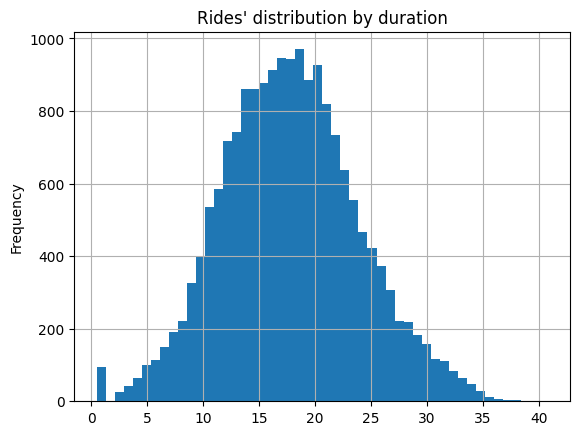

In [12]:
rides['duration'].plot(kind='hist', grid=True, bins=50, title="Rides' distribution by duration");

In [13]:
pd.DataFrame(rides['distance'].describe())

,distance
count,18068.000000
mean,3070.659010
std,1116.832209
min,1.000000
25%,2543.000000
50%,3134.000000
75%,3776.000000
max,7211.000000


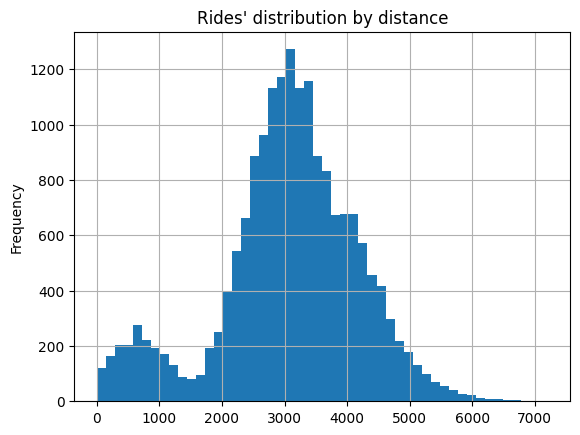

In [14]:
rides['distance'].plot(kind='hist', grid=True, bins=50,
                       title="Rides' distribution by distance");

<div style="font-size:175%; font-weight:bold"> Step 2 conclusion
</div>

        During the data preprocessing duplicates were dropped, added new column with month's number of the rides, rounded distance column. On the distance plot we can see the two pikes. The second pike is caused by normal distribution. The first one is an outlier, caused by most likely by people who had tecnical issues. 

# Step 3. Exploratory data analysis 
<a id="section7"></a> 

In [15]:
#creating pivot table with users' cities
cities = (users[['user_id', 'city']]
          .pivot_table(index='city', aggfunc='count')
          .sort_values(by='user_id', ascending=False)
         )

In [16]:
cities

,user_id
city,
Pyatigorsk,219
Yekaterinburg,204
Rostov-on-Don,198
Krasnodar,193
Sochi,189
Omsk,183
Tyumen,180
Moscow,168


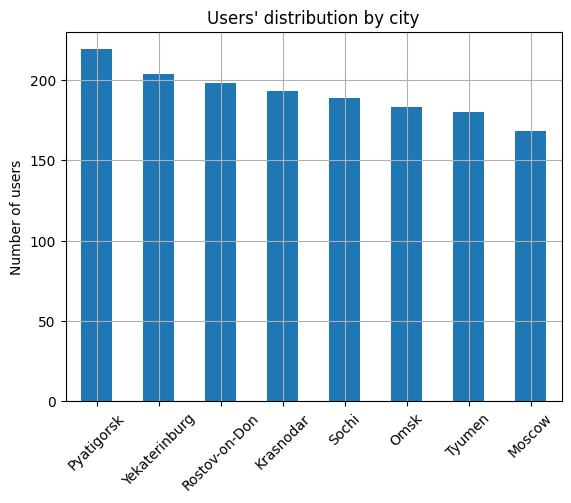

In [17]:
cities.plot(kind='bar', title="Users' distribution by city", legend=False, grid=True)
plt.xlabel('')
plt.ylabel('Number of users')
plt.xticks(rotation=45);

        Service is operating in 8 cities: Yekaterinburg, Krasnodar, Moscow, Omsk, Pyatigorsk, Rostov-on-Don, Sochi, and Tyumen.
        Users' range by city: 168 (Moscow)–219 (Pyatigorsk).
        The users are distributed almost evenly throughout the cities; there is no city that stands out particularly strongly from the others.

In [18]:
#checking how many subsribers of each type are in dataframe
users['subscription_type'].describe()

count     1534
unique       2
top       free
freq       835
Name: subscription_type, dtype: object

In [19]:
#ultra subs
subs = users[users['subscription_type'] == 'ultra']['city'].count()

In [20]:
#free subs
non_subs = users[users['subscription_type'] == 'free']['city'].count()

In [21]:
#function to show the percentages and absolute values of each type at the chart
def autopct_func(a, b):
    c = int(a/100.*sum(b))
    return "{:.1f}%\n({:d})".format(a, c)

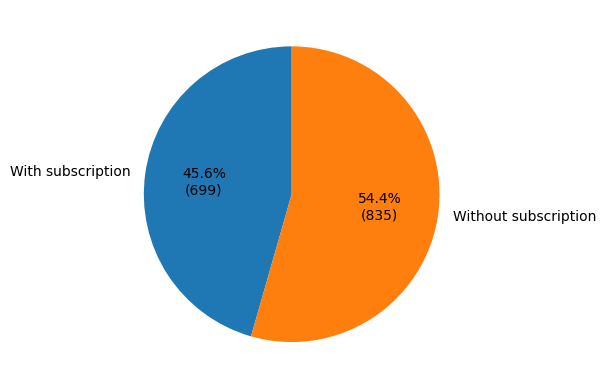

In [22]:
#creating the piechart with subs distribution
plt.pie([subs, non_subs], labels=['With subscription', 'Without subscription'],
        autopct=(lambda p: autopct_func(p, [subs, non_subs])), startangle=90);

         The ratio between ultra and free subscribers is ~36:43 (~45,57%/54,43%). The number of free subscribers is slightly higher than ultra. The revenue generated by different types of users needs to be determined to find out whether the paid subscription is better.

In [23]:
users['age'].describe().astype('int64')

count    1534
mean       24
std         4
min        12
25%        22
50%        25
75%        28
max        43
Name: age, dtype: int64

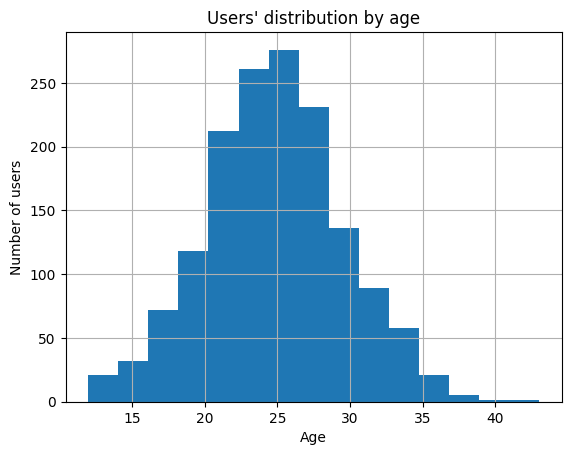

In [24]:
users['age'].plot(kind='hist', title="Users' distribution by age", bins=15, grid=True)
plt.xlabel('Age')
plt.ylabel('Number of users');

        Median age is 25 years. Age spread: 12-43 years. Distribution do not have significant amount of outliers. Interquartile range: 6 years (22-28). In other words, at least half of the users are the older part of youngsters. 

In [25]:
rides['distance'].describe()

count    18068.000000
mean      3070.659010
std       1116.832209
min          1.000000
25%       2543.000000
50%       3134.000000
75%       3776.000000
max       7211.000000
Name: distance, dtype: float64

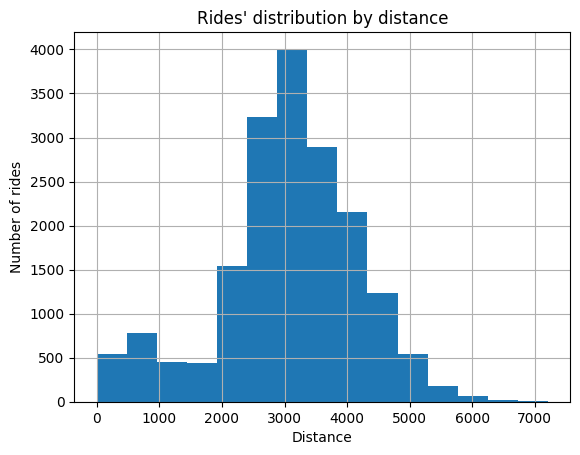

In [26]:
rides['distance'].plot(kind='hist', title="Rides' distribution by distance", grid=True, bins=15)
plt.ylabel('Number of rides')
plt.xlabel('Distance');

        We can see two pikes at the graph. The second pike is part normal distribution. The first pike is the outliers, that most likely caused by people who had technical problems. This data is not an anomaly because the payment for the rides have been received succesfully. 
        Median distance: 3129m.
        Interquartile range: 1224m (2539-3763m).
        According to this data, at least half of the rides are lying within 2.5-3.7 km, which is important to take into account for scooters maintenance and monitoring their status. 

In [27]:
#rounding data in order to simplify the calculation of revenue in the future
rides['duration'] = np.ceil(rides['duration']).astype('int64')

In [28]:
rides['duration'].describe()

count    18068.000000
mean        18.303520
std          6.094928
min          1.000000
25%         14.000000
50%         18.000000
75%         22.000000
max         41.000000
Name: duration, dtype: float64

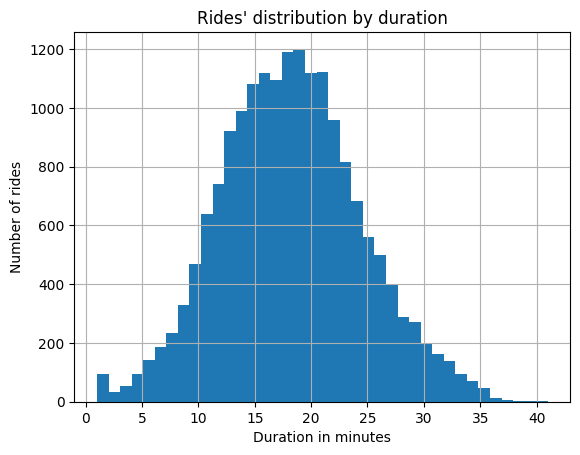

In [29]:
#creating the plot
rides['duration'].plot(kind='hist', title="Rides' distribution by duration", grid=True, bins=39)
plt.xlabel('Duration in minutes')
plt.ylabel('Number of rides');

        The data was rounded for convinience of work. 
        Median: 18 minutes
        Interquartile range: 8 minutes (14-22 minutes)
        Using this data we can approximately understand the scooters status and know the average speed during the ride.

In [30]:
#creating the conclusion dataframe 
conc_df = (pd.DataFrame({'Median': [25, 3129, 18],
                         'Q1': [22, 2539, 14],
                         'Q3': [28, 3763, 22],
                         '': ['Age(y)', 'Distance(m)', 'Duration(min)']})
           .set_index('')
          )
conc_df['IQR'] = conc_df['Q3'] - conc_df['Q1']

<div style='font-size:175%; font-weight:bold'>Step 3 conclusion</div>

        In exploratory data analysis data was examined and visualised.
        The ratio between ultra and free subscribers is ~36:43 (~45,57%/54,43%). The number of free subscribers is slightly higher than ultra. The revenue generated by different types of users needs to be determined to find out whether the paid subscription is better.
        
        Median age: 25 years.
        Age spread: 12-43 years.  
        Interquartile range: 6 years (22-28).
        
        Distribution do not have significant amount of outliers.
        
        In other words, at least half of the users are the older part of youngsters.
        We can see two pikes at the distance graph. The second pike is part normal distribution. The first pike is the outliers, that most likely caused by people who had technical problems. This data is not an anomaly because the payment for the rides have been received succesfully.
        
        Median distance: 3129m.
        Interquartile range: 1224m (2539-3763m).
        
        According to this data, at least half of the rides are lying within 2.5-3.7 km, which is important to take into account for scooters maintenance and monitoring their status. 
        
        The data was rounded to the highest number for convinience of work. 
        Median: 18 minutes.
        Interquartile range: 8 minutes (14-22 minutes).
        
        Using this data we can approximately understand the scooters status and know the average speed during the ride.

In [31]:
conc_df

,Median,Q1,Q3,IQR
,,,,
Age(y),25,22,28,6
Distance(m),3129,2539,3763,1224
Duration(min),18,14,22,8


# Step 4. Merging data
<a id="section8"></a> 

In [32]:
#displaying the shape of all datasets
display(users.shape)
display(rides.shape)
subscriptions.shape

(1534, 5)

(18068, 5)

(2, 4)

        Because the tables are merged on one the columns, so the shape of final dataset must be (18068, 12); 18068 - is the largest rows number among datasets, 12 is the number of columns that will be after the merging(5+5-1+4-1). We substract 1 since we merge on one of the columns each time.

In [33]:
#merging data
data_merged = pd.merge(users, rides, on='user_id', how='left')
data_merged = pd.merge(data_merged, subscriptions, on='subscription_type', how='left')

In [34]:
#displaying the last 10 rows
data_merged.tail(10)

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
18058,1534,Al'bert,25,Krasnodar,free,195.0,7,2021-06-11,6,8,50,0
18059,1534,Al'bert,25,Krasnodar,free,3214.0,19,2021-06-18,6,8,50,0
18060,1534,Al'bert,25,Krasnodar,free,3645.0,21,2021-08-08,8,8,50,0
18061,1534,Al'bert,25,Krasnodar,free,3978.0,27,2021-08-20,8,8,50,0
18062,1534,Al'bert,25,Krasnodar,free,4928.0,23,2021-09-13,9,8,50,0
18063,1534,Al'bert,25,Krasnodar,free,3781.0,20,2021-11-04,11,8,50,0
18064,1534,Al'bert,25,Krasnodar,free,2840.0,22,2021-11-16,11,8,50,0
18065,1534,Al'bert,25,Krasnodar,free,3826.0,19,2021-11-18,11,8,50,0
18066,1534,Al'bert,25,Krasnodar,free,2902.0,17,2021-11-27,11,8,50,0
18067,1534,Al'bert,25,Krasnodar,free,2372.0,16,2021-12-29,12,8,50,0


In [35]:
#checking if the final dataset is sound
data_check(data_merged);

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  int64         
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(6), object(3)
memory usage: 1.6+ MB

Numerical data de

,user_id,age,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
count,18068.000000,18068.000000,18068.000000,18068.000000,18068,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,24.893071,3070.659010,18.303520,2021-06-30 19:47:21.266327296,6.486772,7.280496,32.012398,71.590658
min,1.000000,12.000000,1.000000,1.000000,2021-01-01 00:00:00,1.000000,6.000000,0.000000,0.000000
25%,487.000000,22.000000,2543.000000,14.000000,2021-04-02 00:00:00,4.000000,6.000000,0.000000,0.000000
50%,889.000000,25.000000,3134.000000,18.000000,2021-06-30 00:00:00,6.000000,8.000000,50.000000,0.000000
75%,1213.250000,28.000000,3776.000000,22.000000,2021-09-28 00:00:00,9.000000,8.000000,50.000000,199.000000
max,1534.000000,43.000000,7211.000000,41.000000,2021-12-30 00:00:00,12.000000,8.000000,50.000000,199.000000
std,434.734317,4.582216,1116.832209,6.094928,NaN,3.437410,0.959882,23.997045,95.508238


String data description:


,name,city,subscription_type
count,18068,18068,18068
unique,194,8,2
top,Anna,Pyatigorsk,free
freq,310,2524,11568



First 10 Rows:


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Kira,22,Tyumen,ultra,4410.0,26,2021-01-01,1,6,0,199
1,1,Kira,22,Tyumen,ultra,2618.0,16,2021-01-18,1,6,0,199
2,1,Kira,22,Tyumen,ultra,754.0,7,2021-04-20,4,6,0,199
3,1,Kira,22,Tyumen,ultra,2695.0,19,2021-08-11,8,6,0,199
4,1,Kira,22,Tyumen,ultra,4029.0,27,2021-08-28,8,6,0,199
5,1,Kira,22,Tyumen,ultra,2771.0,17,2021-10-09,10,6,0,199
6,1,Kira,22,Tyumen,ultra,3039.0,15,2021-10-19,10,6,0,199
7,1,Kira,22,Tyumen,ultra,2842.0,24,2021-11-06,11,6,0,199
8,1,Kira,22,Tyumen,ultra,3413.0,16,2021-11-14,11,6,0,199
9,1,Kira,22,Tyumen,ultra,749.0,16,2021-11-22,11,6,0,199



Number of Duplicated Rows:
 0

Missing Values:
 0

DataFrame Shape:
 (18068, 12)


        The tables are merged correctly. The shape meets the requirments. There are no missing values and duplicates.

In [36]:
#creating datasets with paid and free subscribers
subscribed = data_merged[data_merged['subscription_type'] == 'ultra'].reset_index(drop=True)
not_subscribed = data_merged[data_merged['subscription_type'] == 'free'].reset_index(drop=True)

In [37]:
data_check(subscribed);

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   int64         
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int32         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(6), object(3)
memory usage: 584.1+ KB

Numerical data de

,user_id,age,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
count,6500.000000,6500.000000,6500.000000,6500.000000,6500,6500.000000,6500.0,6500.0,6500.0
mean,348.725385,24.892615,3115.443385,19.037692,2021-06-28 21:31:34.153846016,6.422308,6.0,0.0,199.0
min,1.000000,12.000000,244.000000,4.000000,2021-01-01 00:00:00,1.000000,6.0,0.0,199.0
25%,175.000000,22.000000,2785.000000,15.000000,2021-04-01 00:00:00,4.000000,6.0,0.0,199.0
50%,351.000000,25.000000,3149.000000,19.000000,2021-06-27 00:00:00,6.000000,6.0,0.0,199.0
75%,525.000000,28.000000,3561.000000,22.000000,2021-09-25 00:00:00,9.000000,6.0,0.0,199.0
max,699.000000,38.000000,5700.000000,41.000000,2021-12-30 00:00:00,12.000000,6.0,0.0,199.0
std,201.099339,4.757208,836.898137,5.577439,NaN,3.414616,0.0,0.0,0.0


String data description:


,name,city,subscription_type
count,6500,6500,6500
unique,186,8,1
top,Anna,Rostov-on-Don,ultra
freq,107,885,6500



First 10 Rows:


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Kira,22,Tyumen,ultra,4410.0,26,2021-01-01,1,6,0,199
1,1,Kira,22,Tyumen,ultra,2618.0,16,2021-01-18,1,6,0,199
2,1,Kira,22,Tyumen,ultra,754.0,7,2021-04-20,4,6,0,199
3,1,Kira,22,Tyumen,ultra,2695.0,19,2021-08-11,8,6,0,199
4,1,Kira,22,Tyumen,ultra,4029.0,27,2021-08-28,8,6,0,199
5,1,Kira,22,Tyumen,ultra,2771.0,17,2021-10-09,10,6,0,199
6,1,Kira,22,Tyumen,ultra,3039.0,15,2021-10-19,10,6,0,199
7,1,Kira,22,Tyumen,ultra,2842.0,24,2021-11-06,11,6,0,199
8,1,Kira,22,Tyumen,ultra,3413.0,16,2021-11-14,11,6,0,199
9,1,Kira,22,Tyumen,ultra,749.0,16,2021-11-22,11,6,0,199



Number of Duplicated Rows:
 0

Missing Values:
 0

DataFrame Shape:
 (6500, 12)


In [38]:
data_check(not_subscribed);

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11568 entries, 0 to 11567
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  int64         
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int32         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(6), object(3)
memory usage: 1.0+ MB

Numerical data de

,user_id,age,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
count,11568.000000,11568.000000,11568.00000,11568.000000,11568,11568.000000,11568.0,11568.0,11568.0
mean,1120.527230,24.893326,3045.49490,17.890992,2021-07-01 21:47:03.236514560,6.522994,8.0,50.0,0.0
min,700.000000,12.000000,1.00000,1.000000,2021-01-01 00:00:00,1.000000,8.0,50.0,0.0
25%,915.000000,22.000000,2367.00000,13.000000,2021-04-02 00:00:00,4.000000,8.0,50.0,0.0
50%,1123.000000,25.000000,3115.00000,18.000000,2021-07-01 00:00:00,7.000000,8.0,50.0,0.0
75%,1328.000000,28.000000,3906.00000,22.000000,2021-09-30 00:00:00,9.000000,8.0,50.0,0.0
max,1534.000000,43.000000,7211.00000,35.000000,2021-12-30 00:00:00,12.000000,8.0,50.0,0.0
std,241.165628,4.481100,1246.17418,6.330250,NaN,3.449770,0.0,0.0,0.0


String data description:


,name,city,subscription_type
count,11568,11568,11568
unique,190,8,1
top,Anna,Pyatigorsk,free
freq,203,1672,11568



First 10 Rows:


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Ajdar,22,Omsk,free,2516.0,15,2021-01-02,1,8,50,0
1,700,Ajdar,22,Omsk,free,847.0,17,2021-02-01,2,8,50,0
2,700,Ajdar,22,Omsk,free,4004.0,21,2021-02-04,2,8,50,0
3,700,Ajdar,22,Omsk,free,1206.0,10,2021-02-10,2,8,50,0
4,700,Ajdar,22,Omsk,free,3047.0,18,2021-02-14,2,8,50,0
5,700,Ajdar,22,Omsk,free,4342.0,23,2021-02-23,2,8,50,0
6,700,Ajdar,22,Omsk,free,3798.0,19,2021-03-03,3,8,50,0
7,700,Ajdar,22,Omsk,free,2985.0,16,2021-04-09,4,8,50,0
8,700,Ajdar,22,Omsk,free,3360.0,17,2021-06-12,6,8,50,0
9,700,Ajdar,22,Omsk,free,2568.0,12,2021-06-23,6,8,50,0



Number of Duplicated Rows:
 0

Missing Values:
 0

DataFrame Shape:
 (11568, 12)


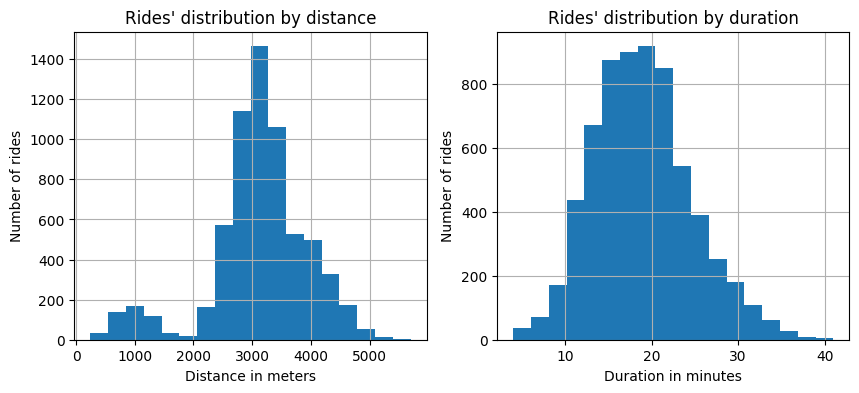

In [39]:
#creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

#inserting the plots
subscribed['distance'].plot(kind='hist', bins=18, ax=axes[0], grid=True,
                                title="Rides' distribution by distance"
                           )

subscribed['duration'].plot(kind='hist', bins=18, ax=axes[1], grid=True,
                                title="Rides' distribution by duration"
                           )

#setting labels
axes[0].set_xlabel('Distance in meters')
axes[0].set_ylabel('Number of rides')

axes[1].set_xlabel('Duration in minutes')
axes[1].set_ylabel('Number of rides');

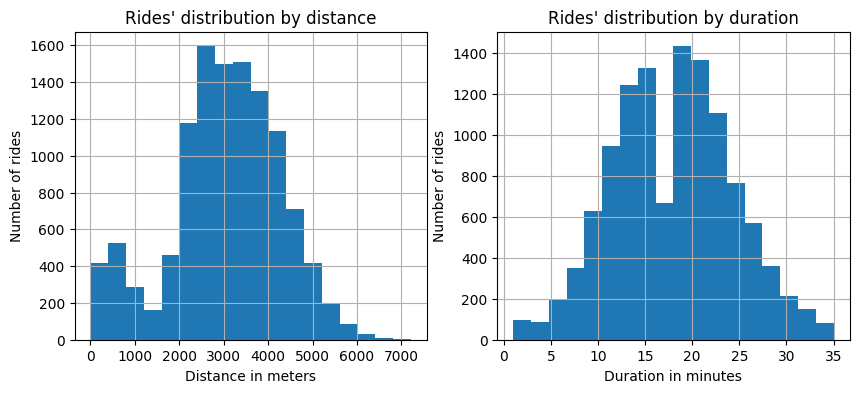

In [40]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

not_subscribed['distance'].plot(kind='hist', bins=18, ax=axes[0], grid=True,
                                title="Rides' distribution by distance")
axes[0].set_xlabel('Distance in meters')
axes[0].set_ylabel('Number of rides')

not_subscribed['duration'].plot(kind='hist', bins=18, ax=axes[1], grid=True,
                                title="Rides' distribution by duration")
axes[1].set_xlabel('Duration in minutes')
axes[1].set_ylabel('Number of rides');

In [41]:
pd.DataFrame(not_subscribed['distance'].describe())

,distance
count,11568.00000
mean,3045.49490
std,1246.17418
min,1.00000
25%,2367.00000
50%,3115.00000
75%,3906.00000
max,7211.00000


<div style="font-size:175%; font-weight:bold">Step 4 conclusion</div>

        The tables are merged correctly. The shape meets the requirments. There are no missing values and duplicates. Next this dataframe was splitted on two separate ones: with paid and free subscribers. As I mentioned before, the two pikes on the distance plot are caused by outlier and normal distribution. So, according to this information, the plots do not have any anomalies.
        
        Paid subscribers:
            Duration:
                Median: 19 min
                Interquartile range: 7 (15-22 min)
            Distance:
                Median: 3149 m
                Interquartile range: 776 (2785-3561 m)
            Age:
                Median: 25 y
                Total range: 12-38 y
                Interquartile range: 6 (22-28 y)

        Free subscribers:
            Duration:
                Median: 18 min
                Interquartile range: 8(14-22 min)
            Distance:
                Median: 3102 m
                Interquartile range: 782 (3102-3884 m)
            Age:
                Median: 25 y
                Total range: 12-43 y
                Interquartile range: 6 (22-28 y)

        There are no significant differences between types of subscribers(less than 5%, except the highest ages).

# Step 5. Revenue calculation
<a id="section9"></a> 

In [42]:
#creating new variable with deepcopy of merged dataframe in it
revenue_data = data_merged.copy(deep=True)

In [43]:
#grouping by month and user ID
revenue_data = (revenue_data
                      .groupby(by=['month', 'user_id'], as_index=False)
                      .agg(duration=('duration', 'sum'),
                           distance=('distance', 'sum'),
                           trip_count=('duration', 'count'),
                          )
                     )

In [44]:
#merging new and sub type dataframes 
revenue_data = revenue_data.merge(users[['user_id', 'subscription_type']], on='user_id', how='left')

In [45]:
#creating a new columns with revenue 
revenue_data.loc[revenue_data['subscription_type'] == 'ultra', 'revenue'] = (
    revenue_data.loc[revenue_data['subscription_type'] == 'ultra', 'duration'] * 6 + 199
)

revenue_data.loc[revenue_data['subscription_type'] == 'free', 'revenue'] = (
    revenue_data.loc[revenue_data['subscription_type'] == 'free', 'duration'] * 8
    + revenue_data.loc[revenue_data['subscription_type'] == 'free', 'trip_count'] * 50
)

In [46]:
#checking
data_check(revenue_data);

Data Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11331 entries, 0 to 11330
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month              11331 non-null  int32  
 1   user_id            11331 non-null  int64  
 2   duration           11331 non-null  int64  
 3   distance           11331 non-null  float64
 4   trip_count         11331 non-null  int64  
 5   subscription_type  11331 non-null  object 
 6   revenue            11331 non-null  float64
dtypes: float64(2), int32(1), int64(3), object(1)
memory usage: 575.5+ KB

Numerical data description:


,month,user_id,duration,distance,trip_count,revenue
count,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000,11331.000000
mean,6.477539,811.061160,29.186127,4896.361045,1.594564,342.303504
std,3.443928,440.350798,16.752464,2911.513832,0.831604,153.875346
min,1.000000,1.000000,1.000000,3.000000,1.000000,58.000000
25%,4.000000,435.000000,17.000000,2972.500000,1.000000,234.000000
50%,6.000000,843.000000,24.000000,3989.000000,1.000000,319.000000
75%,9.000000,1191.000000,38.000000,6421.500000,2.000000,415.000000
max,12.000000,1534.000000,143.000000,23430.000000,7.000000,1444.000000


String data description:


,subscription_type
count,11331
unique,2
top,free
freq,6798



First 10 Rows:


,month,user_id,duration,distance,trip_count,subscription_type,revenue
0,1,1,42,7028.0,2,ultra,451.0
1,1,3,13,3062.0,1,ultra,277.0
2,1,5,13,3915.0,1,ultra,277.0
3,1,7,28,6478.0,2,ultra,367.0
4,1,12,33,3577.0,1,ultra,397.0
5,1,13,42,6688.0,2,ultra,451.0
6,1,14,35,7700.0,2,ultra,409.0
7,1,15,39,4188.0,1,ultra,433.0
8,1,20,29,3517.0,1,ultra,373.0
9,1,22,13,3059.0,1,ultra,277.0



Number of Duplicated Rows:
 0

Missing Values:
 0

DataFrame Shape:
 (11331, 7)


<div style="font-size:175%; font-weight:bold">Step 5 conclusion</div>

        For revenue calculation were created the dataframe with data grouped by month and users. Next, the table with revenue from each user in particular month. So, we can create a hypothesis that looks like this: "The users with paid subscription can generate more revenue, than with free one.". We will check it at the next step.

# Step 6. Hypotheses testing 
<a id='section10'></a>

<div style='font-size:110%; text-indent:60px'>There were three hypothesis that were given by product managers</div>

## Null hypothesis №1:

        The average time of an active session of paid subscribers is equal to free subscribers' one. 
        
**Alternative hypothesis:**

        The average time of an active session of paid subscribers is **NOT** equal to free subscribers' one. 

In [47]:
results = st.ttest_ind(data_merged[data_merged['subscription_type'] == 'ultra']['duration'],
                       data_merged[data_merged['subscription_type'] == 'free']['duration'], alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < 0.05:
    print('Rejecting null hypothesis')
else:
    print('Not rejecting null hypothesis')

p-value: 2.4959453720736625e-34
Rejecting null hypothesis


**1st hypothesis's conclusion:**

        The p-value is too low. Users with paid subscription are NOT prone to spend more time during active session.

## Null hypothesis №2:

    The average distance during one ride is equal to 3130 m.

**Alternative hypothesis:**

    The average distance during one ride is greater than 3130 m. 

In [48]:
results = st.ttest_1samp(data_merged[data_merged['subscription_type'] == 'ultra']['distance'], 3130, alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < 0.05:
    print('Rejecting null hypothesis')
else:
    print('Not rejecting null hypothesis')

p-value: 0.9195649894697725
Not rejecting null hypothesis


**№2 Hypothesis conclusion:**

        p-value is high. Users with paid subscription are prone to ride more than 3130 m.    

## Null hypothesis №3:

        The montly revenue from users with paid subscription is equal to revenue from free subscription users. 

**Alternative hypothesis:**

        The montly revenue from users with paid subscription is greater than revenue from free subscription users

In [49]:
results = st.ttest_ind(revenue_data[revenue_data['subscription_type'] == 'ultra']['revenue'], revenue_data[revenue_data['subscription_type'] == 'free']['revenue'], alternative='greater')
print('p-value:', results.pvalue)
if results.pvalue < 0.05:
    print('Rejecting null hypothesis')
else:
    print('Not rejecting null hypothesis')

p-value: 1.8850394384715216e-31
Rejecting null hypothesis


**№3 hypothesis conclusion:**

        p-value is too low. Users with paid subscription in most of the cases are not generating more revenue than free subscribers. 

<div style="font-size:175%; font-weight:bold">Step 6 conlclusion</div>

        The hypothesises were made by product-managers.
        
        №1 hypothesis conclusion:
        Users with paid subscription are NOT prone to spend more time during active session.

        №2 hypothesis conclusion:
        Users with paid subscription are prone to ride more than 3130 m.

        №3 hypothesis conclusion:
        Users with paid subscription in most of the cases are not generating more revenue than free subscribers. 

# Step 7. Distributions
<a id='section11'></a>

In [50]:
#counting free subscribers
users[users['subscription_type'] == 'free'].count()

user_id              835
name                 835
age                  835
city                 835
subscription_type    835
dtype: int64

In [51]:
#finding the necessary amount of promo-codes to have at least
#100 users move from free to paid subscription
def target_func(p, target):
    n = 835
    while binom.cdf(99, n, p) > 0.05:
        n += 1
    return n
min_n = target_func(0.1, 0.95)
min_n

1161

The probability of that no more than 399.5K users would open the notification: 0.15395843595642772


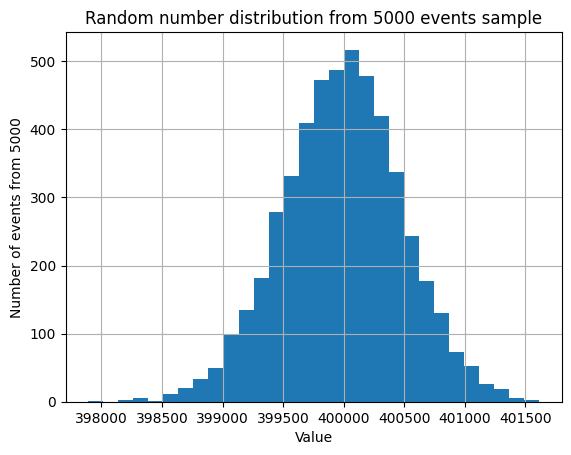

In [52]:
#creating binomial distribution and visualising it 
distr = binom(1000000, 0.4)
samples = distr.rvs(size=5000)
plt.hist(samples, bins=30)
plt.title('Random number distribution from 5000 events sample')
plt.ylabel('Number of events from 5000')
plt.xlabel('Value')
plt.grid(True)
print('The probability of that no more than 399.5K users would open the notification:', distr.cdf(399500))

<div style="font-size:175%; font-weight:bold">Step 7 conclusion</div>

        The necessary amount of sent promocodes to have 100 users move from free to paid subscription is at least 1161. The probability of that no more than 399.5K users would open the notification: 0.154.

# Conclusion

<div style="font-size:150%; font-weight:bold">Step 0. Libs import</div>

        All necessary libs were imported.

<div style="font-size:150%; font-weight:bold">Step 1. Data upload</div>

        The tables were read and saved in variables. One apparent problem in data was found: outliers in distance and duration in the first quarter of data. 

<div style="font-size:150%; font-weight:bold">Step 2. Data preprocessing</div>

        During the data preprocessing duplicates were dropped, added new column with month's number of the rides, rounded distance column. On the distance plot we can see the two pikes. The second pike is caused by normal distribution. The first one is an outlier, caused by most likely by people who had tecnical issues.
<div style="font-size:150%; font-weight:bold">Step 3. Exploratory data analysis</div>

        In exploratory data analysis data was examined and visualised.
        The ratio between ultra and free subscribers is ~36:43 (~45,57%/54,43%). The number of free subscribers is slightly higher than ultra. The revenue generated by different types of users needs to be determined to find out whether the paid subscription is better.
        Median age: 25 years.
        Age spread: 12-43 years.  
        Interquartile range: 6 years (22-28).
        Distribution do not have significant amount of outliers.
        In other words, at least half of the users are the older part of youngsters.
        We can see two pikes at the distance graph. The second pike is part normal distribution. The first pike is the outliers, that most likely caused by people who had technical problems. This data is not an anomaly because the payment for the rides have been received succesfully.
        Median distance: 3129m.
        Interquartile range: 1224m (2539-3763m).
        According to this data, at least half of the rides are lying within 2.5-3.7 km, which is important to take into account for scooters maintenance and monitoring their status. 
        The data was rounded to the highest number for convinience of work. 
        Median: 18 minutes
        Interquartile range: 8 minutes (14-22 minutes)
        Using this data we can approximately understand the scooters status and know the average speed during the ride.
        
<div style="font-size:150%; font-weight:bold">Step 4. Data merge</div>

        The tables are merged correctly. The shape meets the requirments. There are no missing values and duplicates. Next this dataframe was splitted on two separate ones: with paid and free subscribers. As I mentioned before, the two pikes on the distance plot are caused by outlier and normal distribution. So, according to this information, the plots do not have any anomalies.
    
    Paid subscribers:
        Duration:
            Median: 19 min
            Interquartile range: 7 (15-22 min)
        Distance:
            Median: 3149 m
            Interquartile range: 776 (2785-3561 m)
        Age:
            Median: 25 y
            Total range: 12-38 y
            Interquartile range: 6 (22-28 y)

    Free subscribers:
        Duration:
            Median: 18 min
            Interquartile range: 8(14-22 min)
        Distance:
            Median: 3102 m
            Interquartile range: 782 (3102-3884 m)
        Age:
            Median: 25 y
            Total range: 12-43 y
            Interquartile range: 6 (22-28 y)

    There are no significant differences between types of subscribers(less than 5%, except the highest ages).
    
<div style="font-size:150%; font-weight:bold">Step 5. Revenue calculation</div>

        For revenue calculation were created the dataframe with data grouped by month and users. Next, the table with revenue from each user in particular month. So, we can create a hypothesis that looks like this: "The users with paid subscription can generate more revenue, than with free one.". We will check it at the next step.
        
<div style="font-size:150%; font-weight:bold">Step 6. Hypothesis testing</div>

    The hypothesises were made by product-managers.
    
    №1 hypothesis conclusion:
        Users with paid subscription are NOT prone to spend more time during active session.

    №2 hypothesis conclusion:
        Users with paid subscription are prone to ride more than 3130 m.

    №3 hypothesis conclusion:
        Users with paid subscription in most of the cases are not generating more revenue than free subscribers. 
        
<div style="font-size:150%; font-weight:bold">Step 7. Distributions</div>

        The necessary amount of sent promocodes to have 100 users move from free to paid subscription is at least 1161. The probability of that no more than 399.5K users would open the notification: 0.154.
        
<div style="font-size:150%; font-weight:bold">Promocodes</div>

        Previously, the marketing department were sending promocodes for free trial period. After that was found that after free trial 10% of users started using the paid one. So, for switching 100 users to paid subscription with ~95% of probability company should send at least 1161 promocodes.

<div style="font-size:150%; font-weight:bold">Notification</div>

        The marketing department is sending to users notfications in mobile application. It is known that ~40% of users that received the notification open it. The department plans to send 1 million notifications. The probability of that no more than 399.5K users will open it from 1 million messages is ~0.154.
        
<div style="font-size:150%; font-weight:bold">Recommendation</div>

        Knowing the fact that users with different types of subscriptions generate the same amount of revenue and the paid subscribers ride more that optimal distance for scooters, it would be better to advertise the free subscription, because they generate same amount of revenue and less expenses. 